In [4]:
%load_ext autoreload
from tensorboardX import SummaryWriter  
from IPython.core.debugger import set_trace
import os
from collections import defaultdict
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score
from torch.utils.data import DataLoader, Dataset
import torch
from torch import nn
from torch import autograd
import torch.nn.functional as F
import torchvision
import torchio as tio
from models.v2v import V2VModel
import matplotlib.pyplot as plt
import yaml
from easydict import EasyDict as edict
from utils import video_comparison, video, get_capacity
from celluloid import Camera
from IPython.core.display import HTML
from IPython.core.debugger import set_trace
from utils import DiceScoreBinary, DiceLossBinary
from datasets import create_datasets
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
!nvidia-smi

Wed Mar 30 14:21:37 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.27.04    Driver Version: 460.27.04    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce GTX TIT...  Off  | 00000000:02:00.0 Off |                  N/A |
| 22%   38C    P8    14W / 250W |    746MiB / 12211MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX TIT...  Off  | 00000000:03:00.0 Off |                  N/A |
| 49%   

In [199]:
MAKE_LOGS = False
SAVE_MODEL = False
DEVICE = '3'

In [6]:
# logdir = './logs_segpatch/resnet3d_GRID_segpatch_ps64_FCD_bs1_pbs8_pov0.8_lr-1e-3@01.03.2022-03:36:08'
# logdir = './logs_segpatch/v2v128_GRID_segpatch_ps64_FCD_bs1_pbs8_pov0.8_lr-1e-3@01.03.2022-03:36:08'
logdir = logdir = 'logs_segpatch/v2v256_GRID-nG_segpatch_ps64_FCD_bs1_pbs4_pov0.8_lr-1e-3-shuffle-T1w-en-cr@28.03.2022-13:21:24/'
# logdir = 'logs_clf/resnet3d_GRID_ps32_BRATS_bs1_pbs64_pov0.9_clf0.5_fcd0.5_lr-1e-3_AUG@18.02.2022-20:36:13'
# logdir = 'logs_clf/resnet3d_GRID_ps32_FCD_bs1_pbs64_pov0.9_clf0.5_fcd0.5_lr-1e-3_AUG@18.02.2022-20:35:37/'

In [7]:
os.listdir(logdir)

['tb', 'best_val_preds', 'config.yaml', 'checkpoints']

In [8]:
val_preds_path = os.path.join(logdir, 'best_val_preds')

In [9]:
os.listdir(val_preds_path)

['n20', 'n5', 'n70', 'n78', 'G324', 'n66', 'n11', 'G414', 'n15', 'G258']

In [10]:
sorted(os.listdir(os.path.join(logdir, 'checkpoints')))

['weights_0.pth', 'weights_1.pth']

In [11]:
with open(os.path.join(logdir, 'config.yaml')) as fin:
    config = edict(yaml.safe_load(fin))

In [12]:
config

{'make_logs': True,
 'opt': {'device': 0,
  'criterion': 'Dice',
  'start_epoch': 0,
  'n_epochs': 9999,
  'augmentation': False,
  'train_batch_size': 1,
  'val_batch_size': 1,
  'lr': 0.001,
  'save_model': True},
 'model': {'name': 'v2v',
  'output_channels': 1,
  'max_channel_encoder_decoder': 256,
  'sigmoid': True,
  'normalization': 'group_norm',
  'use_greedy_saving': False,
  'target_metric_name': 'dice_score'},
 'dataset': {'save_best_val_predictions': True,
  'trim_background': True,
  'patch_overlap': 0.8,
  'features': ['T1w', 'entropy', 'cr'],
  'root': '/nfs/tom/ibulygin/fcd_data/tensors_all-T1w_ent_cr',
  'metadata_path': 'metadata/metadata_fcd_nG.npy',
  'dataset_type': 'patches_tio',
  'sampler_type': 'grid',
  'patch_size': 64,
  'shuffle_train': True,
  'patch_batch_size': 4}}

In [14]:
config.dataset.root

'/nfs/tom/ibulygin/fcd_data/tensors_all-T1w_ent_cr'

In [15]:
# config.dataset.root = '/nfs/tom/ibulygin/fcd_data/tensors'
# config.dataset.root = '/nfs/tom/ibulygin/fcd_data/brats2020_tensors'

### Load model, setup dataloaders

In [16]:
device = DEVICE if DEVICE=='cpu' else torch.device(f'cuda:{DEVICE}')

# essential for the proper samplers functioning
assert config.opt.val_batch_size == 1
assert config.opt.train_batch_size == 1
assert config.dataset.sampler_type == 'grid'
# assert config.dataset.shuffle_train == False

################
# CREATE MODEL #
################
model = V2VModel(config)#.to(device)
model_capacity = get_capacity(model)
print(f'Model created! Capacity: {model_capacity}')
model_dict = torch.load(os.path.join(logdir, 'checkpoints/weights_1.pth'), map_location=torch.device('cpu'))
print('LOADING from epoch:',model_dict['epoch'])
model.load_state_dict(model_dict['model_state'])

###################
# CREATE DATASETS #
###################
train_dataset, val_dataset = create_datasets(config)
collate_fn = None
train_dataloader = DataLoader(train_dataset,
                                batch_size=config.opt.train_batch_size,
                                shuffle=False,
                                collate_fn=collate_fn)

val_dataloader = DataLoader(val_dataset,
                            batch_size=config.opt.val_batch_size,
                            shuffle=False,
                            collate_fn=collate_fn)

print(len(train_dataloader), len(val_dataloader))

augmentation = None

################
# CREATE OPTIM #
################
criterion = {
    "BCE": nn.BCEWithLogitsLoss(),
    "Dice": DiceLossBinary
}[config.opt.criterion]

print('val dataloder len: ', len(val_dataloader), 'train dataloder len: ', len(train_dataloader))

Model created! Capacity: 46.12
LOADING from epoch: 1
82 10
val dataloder len:  10 train dataloder len:  82


In [46]:
patch_size = config.dataset.patch_size
patch_batch_size = config.dataset.patch_batch_size
patch_overlap = config.dataset.patch_overlap

pov = int(patch_size*patch_overlap) # take high overlap to avoid missing
if pov%2!=0:
    pov+=1

### Load pre-calculated results

In [29]:
best_val_preds = {}
for label in os.listdir(val_preds_path):
    val_preds_label_path = os.path.join(val_preds_path, label)
    best_val_preds[label] = torch.load(val_preds_label_path)[0,0]

In [48]:
dataloader = val_dataloader
labels = dataloader.dataset.labels

# Visualize patches

In [49]:
labels

['n66', 'n70', 'n78', 'n20', 'n15', 'n11', 'n5', 'G414', 'G258', 'G324']

In [53]:
label = 'G414'
label_ind = labels.index(label)

In [55]:
brain_tensor, mask_tensor, label_tensor = dataloader.dataset.__getitem__(label_ind)

In [99]:
Y_slice = label_tensor[0].sum(0).sum(-1).argmax()

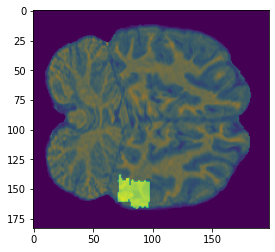

In [100]:
%matplotlib inline
plt.imshow(brain_tensor[0,:,Y_slice,:])
plt.imshow(label_tensor[0,:,Y_slice,:], alpha=0.5)

In [109]:
subject = tio.Subject(t1=tio.ScalarImage(tensor=brain_tensor),
                      label=tio.LabelMap(tensor=label_tensor))


In [123]:
# augmentation
symmetry = tio.RandomFlip(axes=0) 
noise = tio.RandomNoise(std=(0,1e-3))
blur = tio.RandomBlur((0,1e-1))
affine = tio.RandomAffine(scales=(0.95, 1.05, 0.95, 1.05, 0.95, 1.05), 
                         degrees=3,
                         translation=(1,1,1),
                         center='image',
                         default_pad_value=0)
rescale = tio.RescaleIntensity(out_min_max=(0, 1))
augmentation = tio.Compose([symmetry, blur, noise, affine, rescale])

In [124]:
subject_aug = augmentation(subject)

In [125]:
brain_tensor_aug = subject_aug['t1'].tensor
label_tensor_aug = subject_aug['label'].tensor

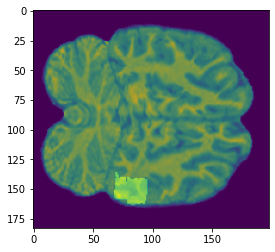

In [126]:
%matplotlib inline
plt.imshow(brain_tensor_aug[0,:,Y_slice,:])
plt.imshow(label_tensor_aug[0,:,Y_slice,:], alpha=0.3)

In [127]:
grid_sampler = tio.inference.GridSampler(subject_aug, patch_size, pov)

patch_loader = torch.utils.data.DataLoader(grid_sampler, batch_size=patch_batch_size, shuffle=True)
aggregator_brain = tio.inference.GridAggregator(grid_sampler, overlap_mode='average')
aggregator_labels = tio.inference.GridAggregator(grid_sampler, overlap_mode='average')

In [209]:
########################
# ITERATE OVER PATCHES #
########################
examples = []
print(f'Iterating for {label}, {len(patch_loader)}')
for patch_i, patches_batch in tqdm(enumerate(patch_loader)):

    inputs = patches_batch['t1'][tio.DATA] # [bs,C,p,p,p]
    targets = patches_batch['label'][tio.DATA] # [bs,1,p,p,p]
    
    examples.append(targets.sum((-1,-2,-3,-4)) > 0)

    locations = patches_batch[tio.LOCATION]
    # casting back to patch
    aggregator_brain.add_batch(inputs, locations)
    aggregator_labels.add_batch(targets, locations)    
    
examples = torch.cat(examples).type(torch.int)

Iterating for G414, 572


572it [00:07, 72.42it/s]


In [211]:
DiceLossBinary(targets, targets)

tensor(0.)

In [238]:
targets_ = torch.zeros_like(targets)
# targets_[0] = torch.ones_like(targets[0])

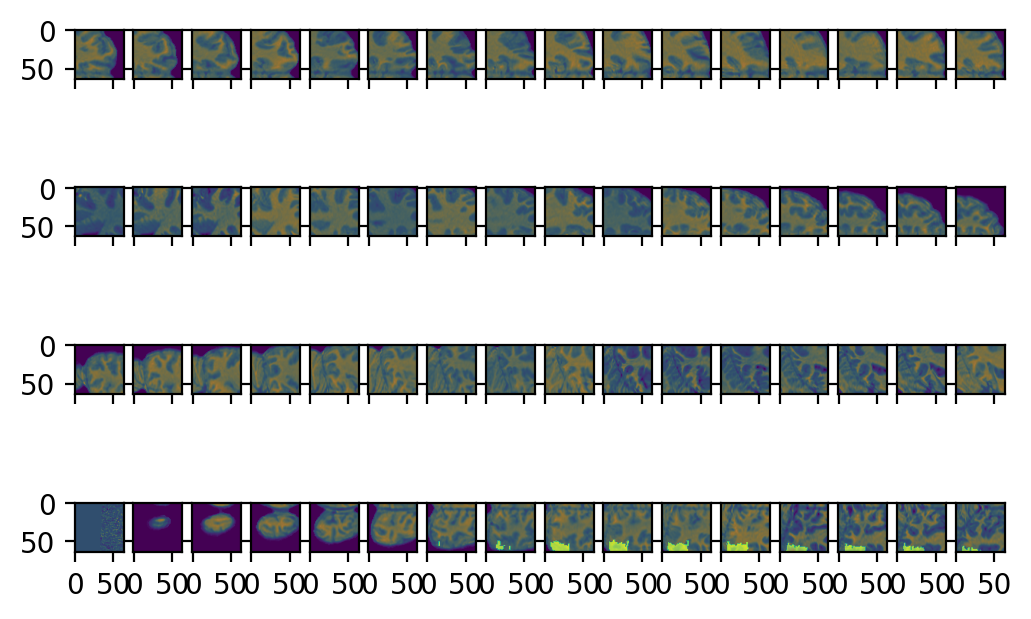

In [150]:
%matplotlib inline
fig, axes = plt.subplots(nrows=patch_batch_size, ncols=patch_size//4, sharex=True, sharey=True, dpi=200)
for i in range(patch_batch_size) :
    for j in range(patch_size//4):
        axes[i,j].imshow(inputs[i,0,:,j*4,:])
        axes[i,j].imshow(targets[i,0,:,j*4,:], alpha=0.5)
        
#         axes.set_xticks([])
#         axes.set_yticks([])
        
# plt.subplots_adjust(left=0.1,
#                     bottom=0.1, 
#                     right=0.9, 
#                     top=0.9, 
#                     wspace=0.4, 
#                     hspace=0.4)
plt.show()

In [129]:
brain_tensor_agg = aggregator_brain.get_output_tensor()
label_tensor_agg = aggregator_labels.get_output_tensor()

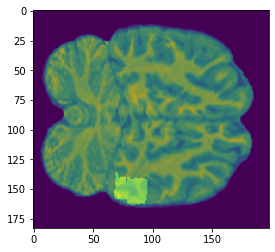

In [130]:
%matplotlib inline
plt.imshow(brain_tensor_agg[0,:,Y_slice,:])
plt.imshow(label_tensor_agg[0,:,Y_slice,:], alpha=0.3)

In [131]:
(brain_tensor_agg - brain_tensor_aug).abs().max()

tensor(3.1590e-06)

# Loss


In [23]:
# train_preds_path = os.path.join(logdir, 'best_train_preds')
# if not os.path.exists(train_preds_path):
#     os.makedirs(train_preds_path)

In [32]:
brains = {}
masks = {}
fcd_true = {}

metric_dict = defaultdict(list)

val_predictions = []

# used to turn on/off gradients
with torch.no_grad():
    iterator = enumerate(dataloader)

    # bs = 1
    # brain_tensor - [1,C,H,W,D]
    # mask_tensor - [1,1,H,W,D]
    # label_tensor - [1,1,H,W,D]
    #######################
    # ITERATE OVER BRAINS #
    #######################
    for iter_i, (brain_tensor, mask_tensor, label_tensor) in tqdm(iterator):

        ###########################
        # SETUP PATCH DATALOADERS #
        ###########################
        label = labels[iter_i]
        
        brains[label] = brain_tensor[0].numpy()
        masks[label] = mask_tensor[0].numpy()
        fcd_true[label] = label_tensor[0].numpy()
        
        continue
        
        subject = tio.Subject(t1=tio.ScalarImage(tensor=brain_tensor[0]),
                              label=tio.LabelMap(tensor=label_tensor[0]))

        grid_sampler = tio.inference.GridSampler(subject, patch_size, pov)
        patch_loader = torch.utils.data.DataLoader(grid_sampler, batch_size=patch_batch_size)
        aggregator = tio.inference.GridAggregator(grid_sampler, overlap_mode='average')

        ########################
        # ITERATE OVER PATCHES #
        #############################################################################
        # number of FCD pixels in patch to be considered as target patch
        metric_dict_patch = defaultdict(list)
        print(f'Iterating for {label}, {len(patch_loader)}')
        for patch_i, patches_batch in tqdm(enumerate(patch_loader)):

            inputs = patches_batch['t1'][tio.DATA].to(device)  # [bs,C,p,p,p]
            targets = patches_batch['label'][tio.DATA].to(device) # [bs,1,p,p,p]

            logits = model(inputs)
            loss = criterion(logits, targets) # [bs,1,p,p,p], [bs,1,p,p,p]
            locations = patches_batch[tio.LOCATION]

            # casting back to patch
            aggregator.add_batch(logits.detach(), locations)

        ########
        # DICE #
        ########
        output_tensor = aggregator.get_output_tensor().unsqueeze(1) # [1,1,H,W,D]
        output_tensor = output_tensor * mask_tensor # zeros all non mask values
        dice = DiceScoreBinary(output_tensor, label_tensor).item()
        coverage = (output_tensor*label_tensor).sum() / label_tensor.sum()
        metric_dict['dice_score'].append(dice)
        metric_dict['coverage'].append(coverage.item())
        
        prediction_dict = {'pred':output_tensor.detach().cpu(),
                           'dice_score':dice,
                           'coverage':coverage.item()}
#                            'brain':brain_tensor.detach().cpu(),
#                            'gt':label_tensor.detach().cpu(),
#                            'mask':mask_tensor.detach().cpu()}

        torch.save(prediction_dict, 
                   os.path.join(train_preds_path, f'{label}'))


10it [00:09,  1.10it/s]


In [33]:
labels

['n66', 'n70', 'n78', 'n20', 'n15', 'n11', 'n5', 'G414', 'G258', 'G324']

In [44]:
label = 'n66'
plt.ioff()
camera = video_comparison([brains[label][0], brains[label][0]], 
                          [fcd_true[label][0], best_val_preds[label]], 
                          n_slides=128,
                          titles=['GT', 'pred'])
animation = camera.animate() # animation ready
HTML(animation.to_html5_video()) # displaying the animation

# Use CRF

In [142]:
ind = np.argmax(dices)

label = predicted_masks[ind]
brain = brain_tensors[ind]
label_gt = real_masks[ind]
dice = dices[ind]

In [143]:
def to_tensor(array):
    return torch.tensor(np.expand_dims(array, axis=(0,1)))

In [144]:
DiceScoreBinary(to_tensor(label), 
                to_tensor(label_gt))

tensor(0.3648)

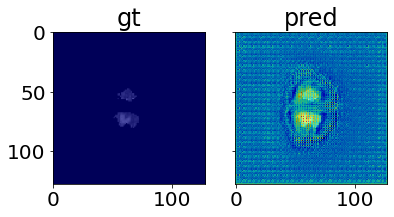

In [148]:
plt.ioff()

camera = video_comparison([brain,brain],
                             [label_gt, label],
                             titles=['gt','pred'])
animation = camera.animate() # animation ready
HTML(animation.to_html5_video()) # displaying the animation

In [149]:
# plt.ioff()
# camera = video(brain,
#                label, 
#               n_slides=128)
# animation = camera.animate() # animation ready
# HTML(animation.to_html5_video()) # displaying the animation

In [ ]:
plt.ioff()
camera = compare(brain,label_gt, 
              n_slides=128)
animation = camera.animate() # animation ready
HTML(animation.to_html5_video()) # displaying the animation

In [37]:
import denseCRF3D

def densecrf3d(I, P, param):
    """
    input parameters:
        I: a numpy array of shape [D, H, W, C], where C is the channel number
           type of I should be np.uint8, and the values are in [0, 255]
        P: a probability map of shape [D, H, W, L], where L is the number of classes
           type of P should be np.float32
        param: a tuple giving parameters of CRF. see the following two examples for details.
    """
    return denseCRF3D.densecrf3d(I, P, param)


dense_crf_param = {}
dense_crf_param['MaxIterations'] = 1.0 #
dense_crf_param['PosW'] = 2.0 #
dense_crf_param['PosRStd'] = 1
dense_crf_param['PosCStd'] = 1
dense_crf_param['PosZStd'] = 1
dense_crf_param['BilateralW'] = 1.0
dense_crf_param['BilateralRStd'] = 1.0
dense_crf_param['BilateralCStd'] = 1.0
dense_crf_param['BilateralZStd'] = 1.0
dense_crf_param['ModalityNum'] = 1
dense_crf_param['BilateralModsStds'] = (1.0,)

brain_prep = (np.expand_dims(brain,-1)*255).astype('uint8')
label_prep = np.stack([1.0 - label, label], axis=-1)

label_crf = densecrf3d(brain_prep, label_prep, dense_crf_param)

Using addPairwiseBilateral for 1 Modality
MaxIterations :1
PosRStd       :1
PosCStd       :1
PosZStd       :1
PosW          :2
BilateralRStd :1
BilateralCStd :1
BilateralZStd :1
ModalityNum   :1
BilateralW    :1
BilateralModsStds:(1)


In [38]:
# plt.ioff()
# camera = video(brain,
#                label_crf, 
#               n_slides=128)
# animation = camera.animate() # animation ready
# HTML(animation.to_html5_video()) # displaying the animation

In [41]:
label_gt.sum()

218.0

In [40]:
label_crf.sum()

4177

In [39]:
DiceScoreBinary(to_tensor(label_crf), 
                to_tensor(label_gt))

tensor(0.)

# Simple thresholding

In [83]:
label_thresh = label.copy()
thresh = 0.5
label_thresh[label_thresh >= thresh] = 1
label_thresh[label_thresh < thresh] = 0

In [131]:
mask = torch.load(val_dataloader.dataset.paths[ind])['mask']
mask = mask[mask.sum(dim=(1,2)) > 0][:,mask.sum(dim=(0,2)) > 0,:][:,:,mask.sum(dim=(0,1)) > 0]
mask = F.interpolate(mask.unsqueeze(0).unsqueeze(0).type(torch.float32),
                    config.interpolation_size).numpy()[0,0] > 0

In [132]:
label.sum() / label_gt.sum()

1.8643723

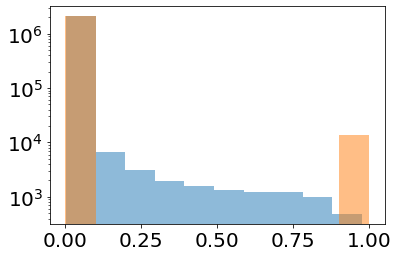

In [133]:
plt.hist(label.flatten(), alpha=0.5)
plt.hist(label_gt.flatten(), alpha=0.5)
plt.yscale('log')
plt.show()

In [134]:
DiceScoreBinary(to_tensor(label_thresh), 
                to_tensor(label_gt))

tensor(0.2977)

(array([7339., 1320.,  843.,  676.,  602.,  578.,  582.,  587.,  625.,
         481.]),
 array([0.00430274, 0.10139041, 0.19847809, 0.29556575, 0.39265344,
        0.48974112, 0.58682877, 0.68391645, 0.78100413, 0.8780918 ,
        0.9751795 ], dtype=float32),
 <BarContainer object of 10 artists>)

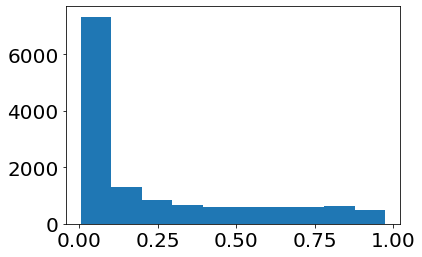

In [135]:
plt.hist(label[label_gt.astype('bool')])

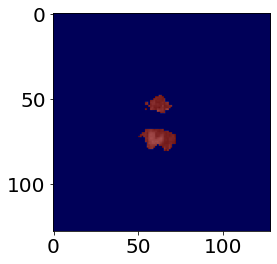

In [136]:
plt.ioff()
camera = video(brain,
               mask, 
              n_slides=128)
animation = camera.animate() # animation ready
HTML(animation.to_html5_video()) # displaying the animation

In [139]:
dice

0.3648377060890198

In [141]:
DiceScoreBinary(to_tensor(label)*mask.astype('int'), 
                to_tensor(label_gt))

tensor(0.3662, dtype=torch.float64)

# Check geom. features concordance

In [53]:
brain_tensor_ = brain_tensor[0].detach().cpu().numpy()

In [22]:
plt.ioff()
camera = video_comparison(brain_tensor_, 
                          n_slides=128)
animation = camera.animate() # animation ready
HTML(animation.to_html5_video()) # displaying the animation

# Check augmentation

In [62]:
brain_tensor_ = brain_tensor[0].detach().cpu().numpy()

symmetry = tio.RandomFlip(axes=0)
bias = tio.RandomBiasField(coefficients=0.3)
noise = tio.RandomNoise(std=(0,1e-3))
affine = tio.RandomAffine(scales=(0.9, 1.1, 0.9, 1.1, 0.9, 1.1), 
                         degrees=15,
                         translation=(1,1,1),
                         center='image',
                         default_pad_value=0)
rescale = tio.RescaleIntensity(out_min_max=(0, 1))
augmentation = tio.Compose([symmetry, bias, noise, affine, rescale]) # , affine

subject = tio.Subject(
            t1=tio.ScalarImage(tensor=brain_tensor_),
            diagnosis='positive'
        )

transformed = augmentation(subject)
brain_tensor_transformed = transformed['t1'].tensor.numpy()

In [88]:
# plt.imshow(brain_tensor_transformed[1,:,10,:])
# plt.colorbar()

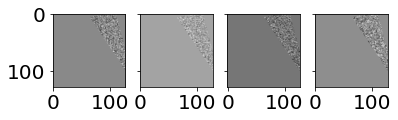

In [75]:
plt.ioff()
camera = video_comparison(brain_tensor_transformed)
animation = camera.animate() # animation ready
HTML(animation.to_html5_video()) # displaying the animation

# Visualize precalculated

In [33]:
logdir = 'logs_segpatch/v2v256_GRID_segpatch_ps64_FCD_bs1_pbs4_pov0.8_lr-1e-3_trainshuffle@11.03.2022-20:29:06'
best_val_preds_path = os.path.join(logdir, 'best_val_preds')

best_val_preds = {}
for val_label in os.listdir(best_val_preds_path):
    pred_path = os.path.join(best_val_preds_path, val_label)
    pred = torch.load(pred_path)
    best_val_preds[val_label] = pred

In [34]:
with open(os.path.join(logdir, 'config.yaml')) as fin:
    config = edict(yaml.safe_load(fin))

In [39]:
train_dataset, val_dataset = create_datasets(config)

val_dataloader = DataLoader(val_dataset,
                            batch_size=config.opt.val_batch_size,
                            shuffle=False,
                            collate_fn=None)

In [40]:
val_dataloader_labels = val_dataloader.dataset.labels

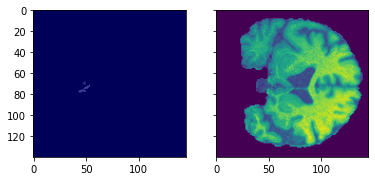

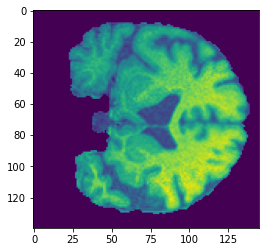

In [50]:
plt.figure()
plt.imshow(brain_tensor[0,1][:,60,:])
plt.show()

In [88]:
brains = []
masks = []
true_masks = []

for iter_i, (brain_tensor, mask_tensor, label_tensor) in enumerate(val_dataloader):
    label = val_dataloader_labels[iter_i]
    brains.append(brain_tensor[0].numpy())
    true_masks.append(label_tensor[0,0].numpy())
    masks.append(best_val_preds[label][0,0])    

In [91]:
ind = 0
plt.ioff()
camera = video_comparison([brains[ind][4], brains[ind][4]], 
               [true_masks[ind], masks[ind]], 
               n_slides=128,
               titles=['GT', 'pred'])
animation = camera.animate() # animation ready
HTML(animation.to_html5_video()) # displaying the animation

SyntaxError: invalid syntax (3902923229.py, line 5)

In [172]:
from scipy.spatial.distance import jensenshannon

In [170]:
val_dataloader_labels

['n15', '30', '49', '41', 'n11', '10', 'n5']

In [182]:
ind = val_dataloader_labels.index('n11')

In [185]:
ind

4

In [183]:
true_masks_bool = true_masks[ind].astype(bool)
features = set(config.dataset.features) - {'label', 'mask'}

references_dist = {}
target_dist = {}
js_dict = {}

for i,f in enumerate(features):
    
    b = brains[ind][i]
    target_dist[f] = b[true_masks_bool]
    references_dist[f] = b.flatten()
    
    hist_ref, _ = np.histogram(references_dist[f], range=(0,1), bins=100)
    hist_ref = hist_ref / hist_ref.sum()
    
    hist_targ, _ = np.histogram(target_dist[f], range=(0,1), bins=100)
    hist_targ = hist_targ / hist_targ.sum()
    
    js_dict[f] = jensenshannon(hist_ref, hist_targ)

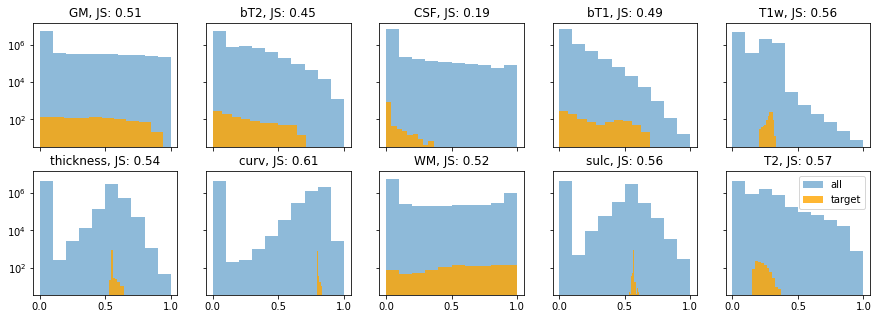

In [184]:
plt.ion()

fig,axes = plt.subplots(ncols=5,nrows=2, figsize=(15,5), sharex=True, sharey=True)

for i,(f,ax) in enumerate(zip(features, axes.flatten())):
    ax.hist(references_dist[f],alpha=0.5, label='all')
    ax.hist(target_dist[f],color='orange', alpha=0.8, label='target')
    ax.set_yscale('log')
    js = np.round(js_dict[f], 2)
    ax.set_title(f'{f}, JS: {js}')
plt.legend()
plt.show()